In [8]:
# Import essential libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

# Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: []


In [9]:
def load_dataset_from_folders(data_dir, img_size=(128, 128)):
    dataset = keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=img_size,
        batch_size=32,
        validation_split=0.3,  # Using 70% train, 30% for val+test
        subset="training",
        seed=42
    )
    
    val_dataset = keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=img_size,
        batch_size=32,
        validation_split=0.3,
        subset="validation",
        seed=42
    )
    
    return dataset, val_dataset

In [10]:
# Create CNN model with 9 output classes and no dropout
def create_cnn():
    model = tf.keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Block  
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        # CORRECT: 9 output units for 9 classes
        layers.Dense(9, activation='softmax')
    ])
    return model

# Create and summarize the model
model = create_cnn()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,004,617 (64.87 MB)

 Trainable params: 17,004,617 (64.87 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Load datasets directly
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/realwaste/RealWaste_split/train",
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.3,
    subset="training",
    seed=42,
    label_mode='int'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/realwaste/RealWaste_split/train", 
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.3,
    subset="validation",
    seed=42,
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/realwaste/RealWaste_split/test",
    image_size=(128, 128),
    batch_size=32,
    shuffle=False,
    label_mode='int'
)

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")
print(f"Classes: {train_dataset.class_names}")
print(f"Number of classes: {len(train_dataset.class_names)}")

Found 3323 files belonging to 9 classes.
Using 2327 files for training.
Found 3323 files belonging to 9 classes.
Using 996 files for validation.
Found 719 files belonging to 9 classes.
Training batches: 73
Validation batches: 32
Test batches: 23
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Number of classes: 9


In [12]:
# Compile with Adam optimizer
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Train the model for 20 epochs
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 597ms/step - accuracy: 0.1682 - loss: 71.3053 - val_accuracy: 0.2410 - val_loss: 2.0214
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 593ms/step - accuracy: 0.2460 - loss: 2.0197 - val_accuracy: 0.2098 - val_loss: 2.1452
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 81s 580ms/step - accuracy: 0.2253 - loss: 2.0899 - val_accuracy: 0.2269 - val_loss: 2.0965
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 594ms/step - accuracy: 0.2970 - loss: 1.9053 - val_accuracy: 0.2922 - val_loss: 2.1100
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 595ms/step - accuracy: 0.3822 - loss: 1.7312 - val_accuracy: 0.3474 - val_loss: 1.9188
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 44s 602ms/step - accuracy: 0.4796 - loss: 1.4980 - val_accuracy: 0.3584 - val_loss: 1.9787
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 82s 606ms/step - accuracy: 0.5330 - loss: 1.3141 - val_accuracy: 0.3926 - val_loss: 1.9617
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 80s 580ms/step - accuracy: 0.6132 - loss: 1.1005 - val_acc

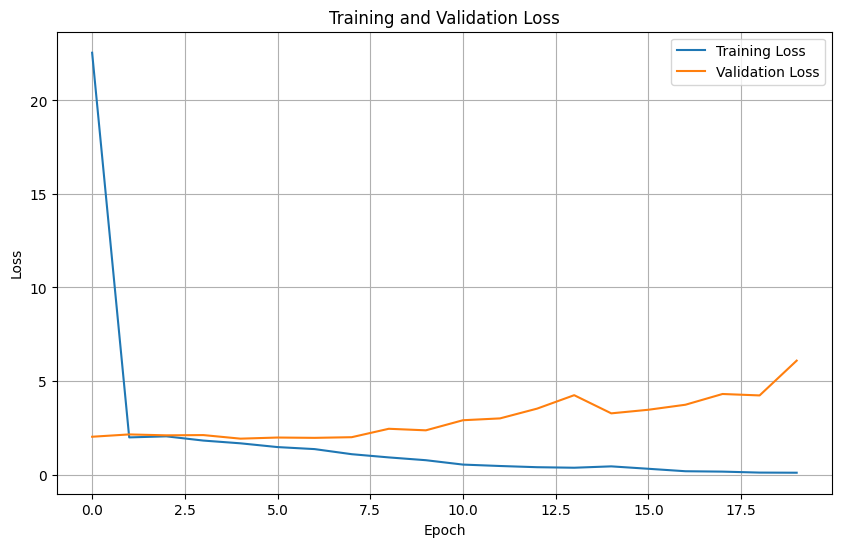

In [14]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

=== FINAL MODEL EVALUATION ON TEST SET ===
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.4238 - loss: 5.3981
🎯 TEST Accuracy: 0.4186
🎯 TEST Loss: 5.5756
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9615 - loss: 0.1332
📊 TRAIN Accuracy: 0.9678
Generating predictions for test set...


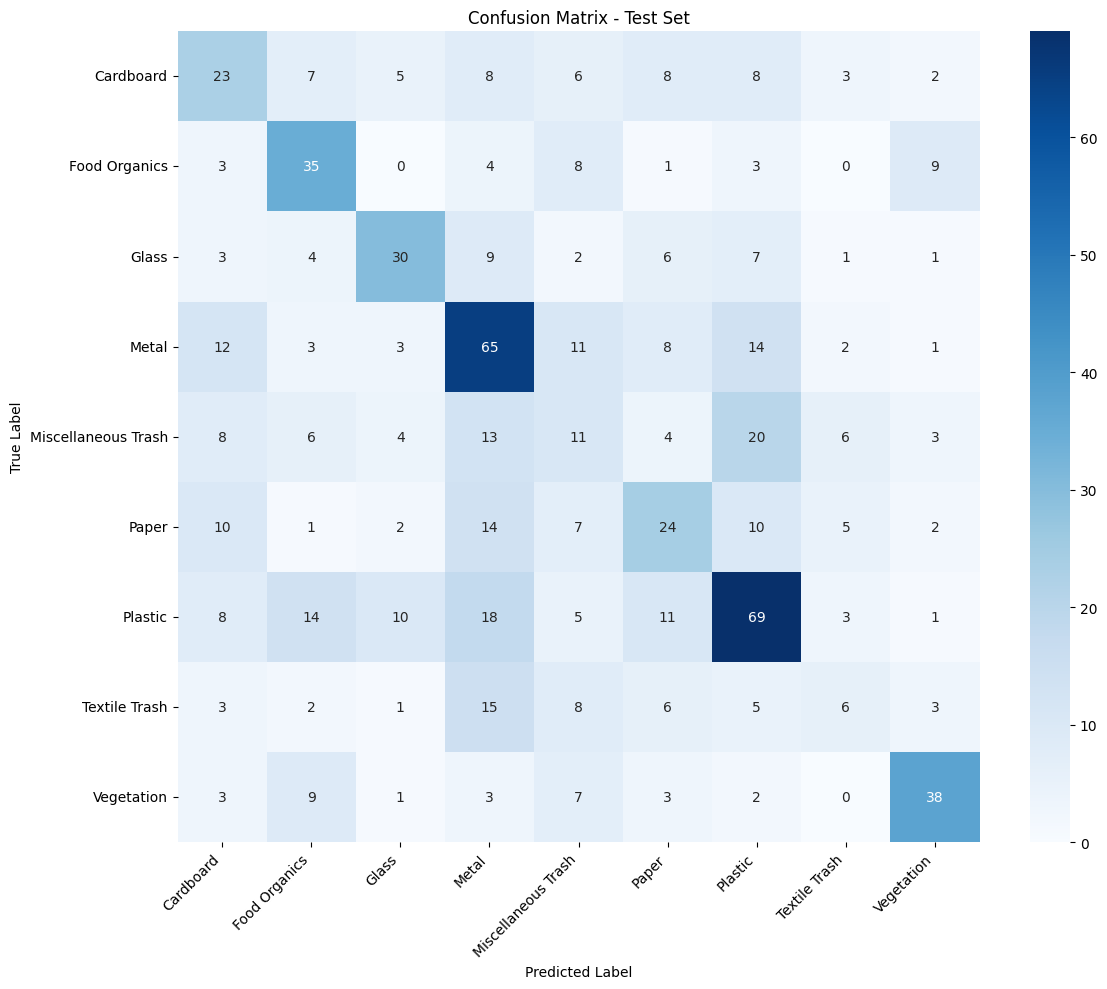

📊 Classification Report - Test Set:
                     precision    recall  f1-score   support

          Cardboard     0.3151    0.3286    0.3217        70
      Food Organics     0.4321    0.5556    0.4861        63
              Glass     0.5357    0.4762    0.5042        63
              Metal     0.4362    0.5462    0.4851       119
Miscellaneous Trash     0.1692    0.1467    0.1571        75
              Paper     0.3380    0.3200    0.3288        75
            Plastic     0.5000    0.4964    0.4982       139
      Textile Trash     0.2308    0.1224    0.1600        49
         Vegetation     0.6333    0.5758    0.6032        66

           accuracy                         0.4186       719
          macro avg     0.3989    0.3964    0.3938       719
       weighted avg     0.4111    0.4186    0.4116       719



In [15]:
# Evaluate on UNSEEN test data
print("=== FINAL MODEL EVALUATION ON TEST SET ===")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"🎯 TEST Accuracy: {test_accuracy:.4f}")
print(f"🎯 TEST Loss: {test_loss:.4f}")

# Also get training accuracy for comparison
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"📊 TRAIN Accuracy: {train_accuracy:.4f}")

# Get predictions for confusion matrix and metrics
y_true = []
y_pred = []

print("Generating predictions for test set...")
for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.class_names,
            yticklabels=train_dataset.class_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Precision, Recall, F1-Score
print("📊 Classification Report - Test Set:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=train_dataset.class_names, digits=4))